# Playing with hydro outputs

This is basically copying the getting_started notebook in the beginning. First we have to initialize the OGGM session.

In [1]:
from matplotlib import pyplot as plt
from oggm import utils, cfg
cfg.initialize(logging_level='WARNING')

2021-04-19 09:10:39: oggm.cfg: Reading default parameters from the OGGM `params.cfg` configuration file.
2021-04-19 09:10:39: oggm.cfg: Multiprocessing switched OFF according to the parameter file.
2021-04-19 09:10:39: oggm.cfg: Multiprocessing: using all available processors (N=8)


In [2]:
# We want multiprocessing
cfg.PARAMS['use_multiprocessing'] = True

2021-04-19 09:10:39: oggm.cfg: Multiprocessing switched ON after user settings.


# Workflow
When this is done, we can begin with the workflow.

In [3]:
from oggm import workflow

In [4]:
# Set the working dir.
cfg.PATHS['working_dir'] = '/home/erik/data/oggm_output/'
cfg.PATHS['working_dir']

'/home/erik/data/oggm_output/'

For this test we will use two glaciers:
* Unteraar Glacier
* Hintereisferner

In [5]:
rgi_ids = ['RGI60-11.01328', 'RGI60-11.00897']

and now we can initialize our glacier directories

In [6]:
gdirs = workflow.init_glacier_directories(rgi_ids)

2021-04-19 09:10:39: oggm.workflow: Execute entity task GlacierDirectory on 2 glaciers


Look at how pretty Hintereisferner is

In [7]:
from oggm import graphics

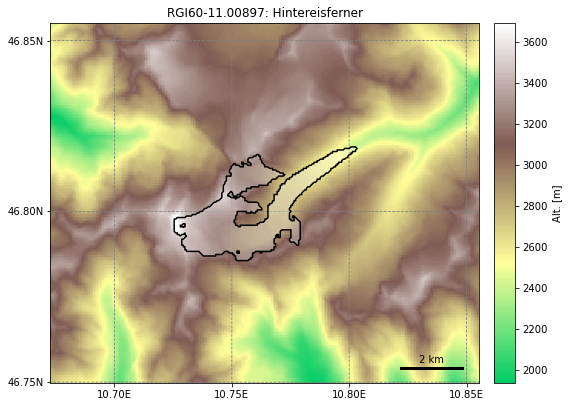

In [8]:
graphics.plot_domain(gdirs[1], figsize=(8,7))

## Tasks
We can begin to perform tasks on our glaciers.

In [9]:
from oggm import tasks

In [10]:
# Create glaciers masks
workflow.execute_entity_task(tasks.glacier_masks, gdirs)

2021-04-19 09:10:41: oggm.workflow: Execute entity task glacier_masks on 2 glaciers


[None, None]

We also need centerlines, flowlines and the downstream line

In [11]:
task_list = [
    tasks.compute_centerlines,
    tasks.initialize_flowlines,
    tasks.compute_downstream_line
]
# Handy to loop over all the tasks
for task in task_list:
    workflow.execute_entity_task(task, gdirs)

2021-04-19 09:10:41: oggm.workflow: Execute entity task compute_centerlines on 2 glaciers
2021-04-19 09:10:41: oggm.workflow: Execute entity task initialize_flowlines on 2 glaciers
2021-04-19 09:10:41: oggm.workflow: Execute entity task compute_downstream_line on 2 glaciers


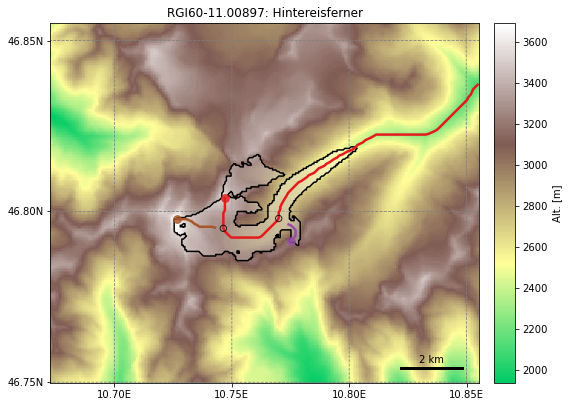

In [12]:
# We can plot the centerlines to take a look
graphics.plot_centerlines(gdirs[1], figsize=(8,7), use_flowlines=True, add_downstream=True)

## More preprocessing

In [13]:
task_list = [
    tasks.catchment_area,
    tasks.catchment_width_geom,
    tasks.catchment_width_correction,
    tasks.compute_downstream_bedshape
]
for task in task_list:
    workflow.execute_entity_task(task, gdirs)

2021-04-19 09:10:42: oggm.workflow: Execute entity task catchment_area on 2 glaciers
2021-04-19 09:10:44: oggm.workflow: Execute entity task catchment_width_geom on 2 glaciers
2021-04-19 09:10:45: oggm.workflow: Execute entity task catchment_width_correction on 2 glaciers
2021-04-19 09:10:45: oggm.workflow: Execute entity task compute_downstream_bedshape on 2 glaciers


Now we know the catchment area of our glaciers

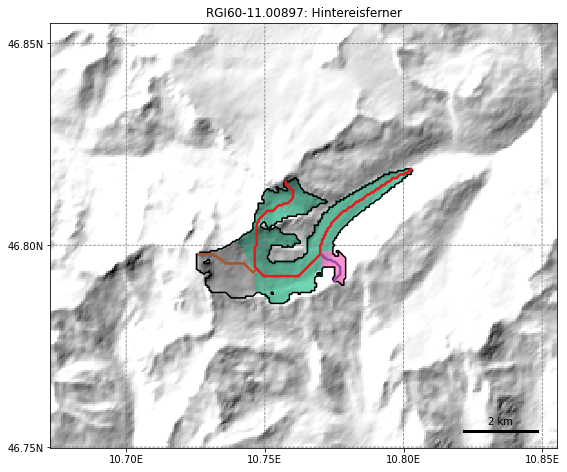

In [14]:
graphics.plot_catchment_areas(gdirs[1], figsize=(8,7))

and the catchment widths:

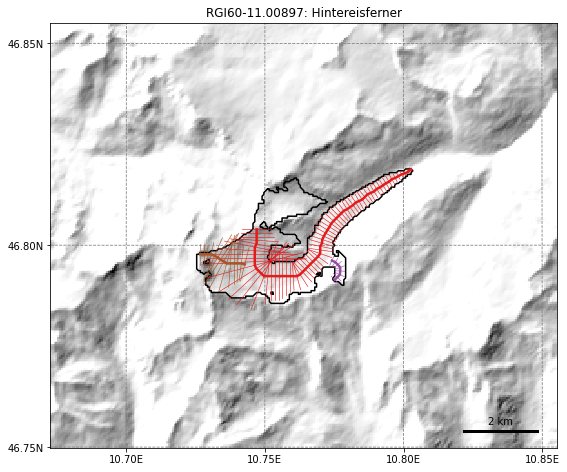

In [15]:
graphics.plot_catchment_width(gdirs[1], corrected=True, figsize=(8,7))

## Climate
Lets take a look at the climate data for our glaciers

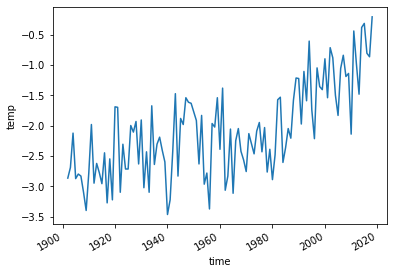

In [16]:
import xarray as xr
fpath = gdirs[1].get_filepath('climate_historical')
ds = xr.open_dataset(fpath)
ds.temp.resample(time='AS').mean()[1:-1].plot();

Lets calibrate the mass balance model. First we need to fetch the reference t*

In [17]:
# This is where we get t*
params_url = 'https://cluster.klima.uni-bremen.de/~oggm/ref_mb_params/oggm_v1.4/RGIV62/CRU/centerlines/qc3/pcp2.5'
workflow.download_ref_tstars(base_url=params_url)

In [18]:
# This is the actual calibration
workflow.execute_entity_task(tasks.local_t_star, gdirs)
workflow.execute_entity_task(tasks.mu_star_calibration, gdirs);

2021-04-19 09:10:47: oggm.workflow: Execute entity task local_t_star on 2 glaciers
2021-04-19 09:10:47: oggm.workflow: Execute entity task mu_star_calibration on 2 glaciers
/home/erik/dev/oggm-fork/oggm/core/flowline.py:2216: UserWarning: Mass balance is computed yearly. If you want output to reflect monthly processes set mb_elev_feedback = 'monthly'
  warnings.warn("The mass-balance used to drive the ice dynamics model "
/home/erik/dev/oggm-fork/oggm/core/flowline.py:2216: UserWarning: Mass balance is computed yearly. If you want output to reflect monthly processes set mb_elev_feedback = 'monthly'
  warnings.warn("The mass-balance used to drive the ice dynamics model "
2021-04-19 09:24:50: oggm.core.flowline: ValueError occurred during task run_with_hydro_monthly_hydro__CCSM4_rcp26 on RGI60-15.03733: Unable to update size for existing dimension'time' (82 != 973)
2021-04-19 09:24:52: oggm.core.flowline: ValueError occurred during task run_with_hydro_monthly_hydro__CCSM4_rcp26 on RGI60-

Compute the ice thickness (inversion)

In [19]:
task_list = [
    tasks.prepare_for_inversion,
    tasks.mass_conservation_inversion,
    tasks.filter_inversion_output
]
for task in task_list:
    workflow.execute_entity_task(task, gdirs)

2021-04-19 09:10:47: oggm.workflow: Execute entity task prepare_for_inversion on 2 glaciers
2021-04-19 09:10:47: oggm.workflow: Execute entity task mass_conservation_inversion on 2 glaciers
2021-04-19 09:10:47: oggm.workflow: Execute entity task filter_inversion_output on 2 glaciers


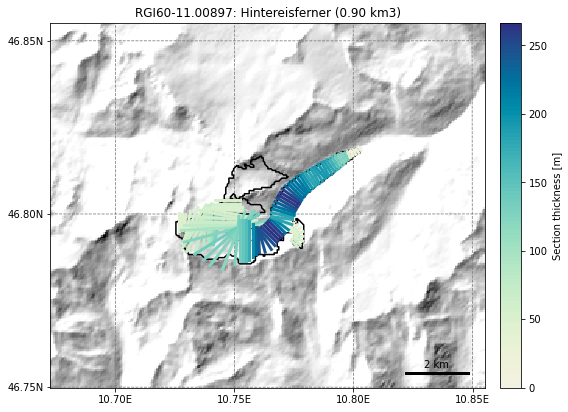

In [20]:
graphics.plot_inversion(gdirs[1], figsize=(8,7))

## Simulations
Preprocessing is done and we're ready to do some simulations. Lets try if the hydro works.

In [21]:
# First convert flowlines to a glacier
workflow.execute_entity_task(tasks.init_present_time_glacier, gdirs);

2021-04-19 09:10:49: oggm.workflow: Execute entity task init_present_time_glacier on 2 glaciers


In [22]:
# Lets try hydro task.
workflow.execute_entity_task(tasks.run_with_hydro, gdirs, run_task=tasks.run_random_climate,
                             nyears=200, y0=2000, output_filesuffix='_2000_hydro')

2021-04-19 09:10:49: oggm.workflow: Execute entity task run_with_hydro on 2 glaciers


Complie the runs for now to have something to look at

In [23]:
ds_hydro = utils.compile_run_output(gdirs, input_filesuffix='_2000_hydro')

2021-04-19 09:11:02: oggm.utils: Applying global task compile_run_output on 2 glaciers
2021-04-19 09:11:02: oggm.utils: Applying compile_run_output on 2 gdirs.


In [24]:
ds_hydro

<xarray.Dataset>
Dimensions:               (rgi_id: 2, time: 201)
Coordinates:
  * time                  (time) float64 0.0 1.0 2.0 3.0 ... 198.0 199.0 200.0
  * rgi_id                (rgi_id) <U14 'RGI60-11.01328' 'RGI60-11.00897'
    hydro_year            (time) int64 0 1 2 3 4 5 6 ... 195 196 197 198 199 200
    hydro_month           (time) int64 1 1 1 1 1 1 1 1 1 1 ... 1 1 1 1 1 1 1 1 1
    calendar_year         (time) int64 -1 0 1 2 3 4 ... 194 195 196 197 198 199
    calendar_month        (time) int64 10 10 10 10 10 10 ... 10 10 10 10 10 10
Data variables: (12/21)
    volume                (time, rgi_id) float64 3.577e+09 ... 2.393e+08
    volume_bsl            (time, rgi_id) float64 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0
    volume_bwl            (time, rgi_id) float64 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0
    area                  (time, rgi_id) float64 2.382e+07 ... 4.365e+06
    length                (time, rgi_id) float64 1.342e+04 6.9e+03 ... 1.5e+03
    calving               (time, rgi_id) float64 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0
    ...                    ...
    snow_bucket           (time, rgi_id) float64 0.0 0.0 ... 2.571e+10 0.0
    model_mb              (time, rgi_id) float64 -2.598e+10 -7.267e+09 ... nan
    residual_mb           (time, rgi_id) float64 8.377e+07 8.911e+07 ... nan nan
    water_level           (rgi_id) float64 0.0 0.0
    glen_a                (rgi_id) float64 2.4e-24 2.4e-24
    fs                    (rgi_id) float64 0.0 0.0
Attributes:
    description:    OGGM model output
    oggm_version:   1.4.1.dev17+g4bbd819
    calendar:       365-day no leap
    creation_date:  2021-04-19 07:11:02

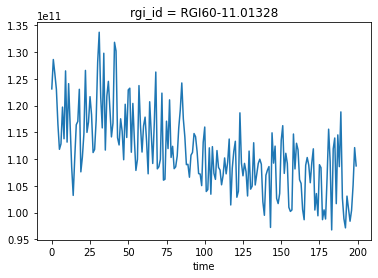

In [25]:
melt_water = ds_hydro.melt_off_glacier + ds_hydro.melt_on_glacier + ds_hydro.liq_prcp_off_glacier + ds_hydro.liq_prcp_on_glacier
melt_water.isel(rgi_id=0).plot()

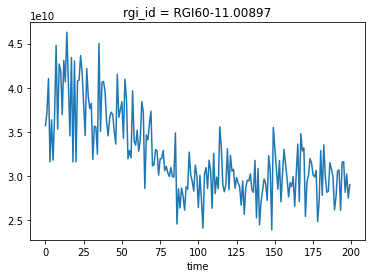

In [26]:
melt_water.isel(rgi_id=1).plot()

# Hydro and climate data

In [27]:
from oggm.shop import gcm_climate

In [28]:
rgi_ids = utils.get_rgi_glacier_entities(['RGI60-15.03473', 'RGI60-15.03733'])
gdirs = workflow.init_glacier_directories(rgi_ids, from_prepro_level=5)

2021-04-19 09:11:04: oggm.workflow: init_glacier_directories from prepro level 5 on 2 glaciers.
2021-04-19 09:11:04: oggm.workflow: Execute entity task gdir_from_prepro on 2 glaciers


2021-04-19 09:11:04: oggm.utils: Applying global task compile_run_output on 2 glaciers
2021-04-19 09:11:04: oggm.utils: Applying compile_run_output on 2 gdirs.


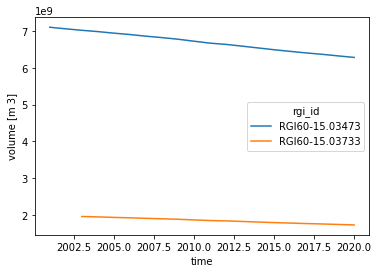

In [29]:
ds = utils.compile_run_output(gdirs, input_filesuffix='_historical')
ds.volume.plot(hue='rgi_id');

## Climate data

In [30]:
bp = 'https://cluster.klima.uni-bremen.de/~oggm/cmip5-ng/pr/pr_mon_CCSM4_{}_r1i1p1_g025.nc'
bt = 'https://cluster.klima.uni-bremen.de/~oggm/cmip5-ng/tas/tas_mon_CCSM4_{}_r1i1p1_g025.nc'
for rcp in ['rcp26', 'rcp45', 'rcp60', 'rcp85']:
    # Download the files
    ft = utils.file_downloader(bt.format(rcp))
    fp = utils.file_downloader(bp.format(rcp))
    # bias correct them
    workflow.execute_entity_task(gcm_climate.process_cmip_data, gdirs, 
                                 filesuffix='_CCSM4_{}'.format(rcp),  # recognize the climate file for later
                                 fpath_temp=ft,  # temperature projections
                                 fpath_precip=fp,  # precip projections
                                 );

2021-04-19 09:11:05: oggm.workflow: Execute entity task process_cmip_data on 2 glaciers
2021-04-19 09:11:07: oggm.workflow: Execute entity task process_cmip_data on 2 glaciers
2021-04-19 09:11:09: oggm.workflow: Execute entity task process_cmip_data on 2 glaciers
2021-04-19 09:11:10: oggm.workflow: Execute entity task process_cmip_data on 2 glaciers


## Projection runs

In [31]:
for rcp in ['rcp26', 'rcp45', 'rcp60', 'rcp85']:
    rid = f'_CCSM4_{rcp}'
    workflow.execute_entity_task(tasks.run_with_hydro,
                                 gdirs,
                                 run_task=tasks.run_from_climate_data,
                                 climate_filename='gcm_data',
                                 climate_input_filesuffix=rid,
                                 init_model_filesuffix='_historical',
                                 output_filesuffix=rid,
                                );

2021-04-19 09:11:11: oggm.workflow: Execute entity task run_with_hydro on 2 glaciers
2021-04-19 09:11:14: oggm.workflow: Execute entity task run_with_hydro on 2 glaciers
2021-04-19 09:11:17: oggm.workflow: Execute entity task run_with_hydro on 2 glaciers
2021-04-19 09:11:20: oggm.workflow: Execute entity task run_with_hydro on 2 glaciers


**Plotting**

Lets first take a look at the volume changes

2021-04-19 09:11:22: oggm.utils: Applying global task compile_run_output on 2 glaciers
2021-04-19 09:11:22: oggm.utils: Applying compile_run_output on 2 gdirs.
2021-04-19 09:11:23: oggm.utils: Applying global task compile_run_output on 2 glaciers
2021-04-19 09:11:23: oggm.utils: Applying compile_run_output on 2 gdirs.
2021-04-19 09:11:23: oggm.utils: Applying global task compile_run_output on 2 glaciers
2021-04-19 09:11:23: oggm.utils: Applying compile_run_output on 2 gdirs.
2021-04-19 09:11:23: oggm.utils: Applying global task compile_run_output on 2 glaciers
2021-04-19 09:11:23: oggm.utils: Applying compile_run_output on 2 gdirs.


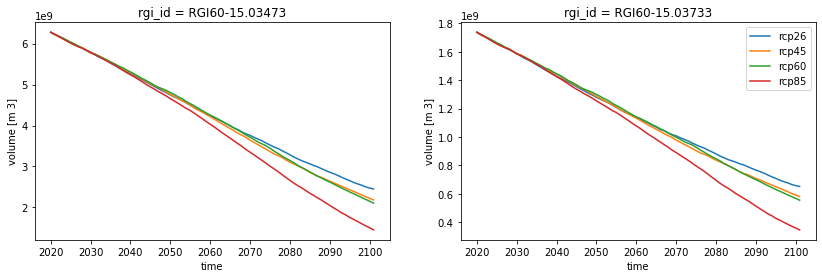

In [32]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 4))
for rcp in ['rcp26', 'rcp45', 'rcp60', 'rcp85']:
    rid = f'_CCSM4_{rcp}'
    ds = utils.compile_run_output(gdirs, input_filesuffix=rid)
    ds.isel(rgi_id=0).volume.plot(ax=ax1, label=rcp)
    ds.isel(rgi_id=1).volume.plot(ax=ax2, label=rcp)
plt.legend();

And lets modify this somewhat to have a look at the meltwater output

2021-04-19 09:11:23: oggm.utils: Applying global task compile_run_output on 2 glaciers
2021-04-19 09:11:23: oggm.utils: Applying compile_run_output on 2 gdirs.
2021-04-19 09:11:23: oggm.utils: Applying global task compile_run_output on 2 glaciers
2021-04-19 09:11:23: oggm.utils: Applying compile_run_output on 2 gdirs.
2021-04-19 09:11:23: oggm.utils: Applying global task compile_run_output on 2 glaciers
2021-04-19 09:11:23: oggm.utils: Applying compile_run_output on 2 gdirs.
2021-04-19 09:11:23: oggm.utils: Applying global task compile_run_output on 2 glaciers
2021-04-19 09:11:23: oggm.utils: Applying compile_run_output on 2 gdirs.


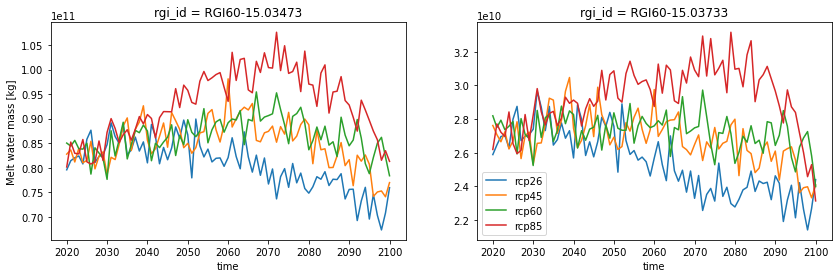

In [33]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 4))
for rcp in ['rcp26', 'rcp45', 'rcp60', 'rcp85']:
    rid = f'_CCSM4_{rcp}'
    ds = utils.compile_run_output(gdirs, input_filesuffix=rid)
    ds_hydro = ds.melt_on_glacier + ds.melt_off_glacier +\
    ds.liq_prcp_off_glacier + ds.liq_prcp_on_glacier
    ds_hydro.isel(rgi_id=0).plot(ax=ax1, label=rcp)
    ds_hydro.isel(rgi_id=1).plot(ax=ax2, label=rcp)
    ax1.set_ylabel('Melt water mass [kg]')
plt.legend();

Smooth the output a little bit (make it pretty)

2021-04-19 09:11:24: oggm.utils: Applying global task compile_run_output on 2 glaciers
2021-04-19 09:11:24: oggm.utils: Applying compile_run_output on 2 gdirs.
2021-04-19 09:11:24: oggm.utils: Applying global task compile_run_output on 2 glaciers
2021-04-19 09:11:24: oggm.utils: Applying compile_run_output on 2 gdirs.
2021-04-19 09:11:24: oggm.utils: Applying global task compile_run_output on 2 glaciers
2021-04-19 09:11:24: oggm.utils: Applying compile_run_output on 2 gdirs.
2021-04-19 09:11:24: oggm.utils: Applying global task compile_run_output on 2 glaciers
2021-04-19 09:11:24: oggm.utils: Applying compile_run_output on 2 gdirs.


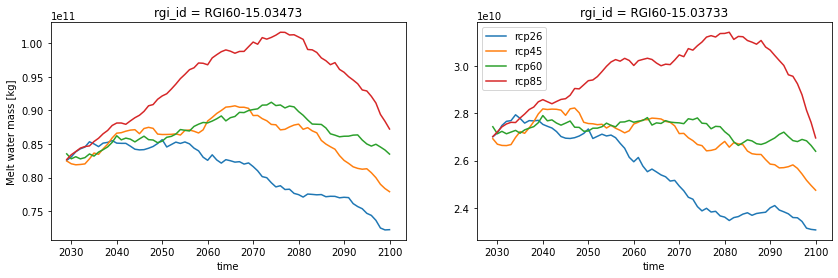

In [34]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 4))
for rcp in ['rcp26', 'rcp45', 'rcp60', 'rcp85']:
    rid = f'_CCSM4_{rcp}'
    ds = utils.compile_run_output(gdirs, input_filesuffix=rid)
    ds_hydro = ds.melt_on_glacier + ds.melt_off_glacier + ds.liq_prcp_off_glacier +\
    ds.liq_prcp_on_glacier
    ds_hydro = ds_hydro.rolling(time=10).mean()
    ds_hydro.isel(rgi_id=0).plot(ax=ax1, label=rcp)
    ds_hydro.isel(rgi_id=1).plot(ax=ax2, label=rcp)
    ax1.set_ylabel('Melt water mass [kg]')
plt.legend();

2021-04-19 09:11:24: oggm.utils: Applying global task compile_run_output on 2 glaciers
2021-04-19 09:11:24: oggm.utils: Applying compile_run_output on 2 gdirs.
2021-04-19 09:11:24: oggm.utils: Applying global task compile_run_output on 2 glaciers
2021-04-19 09:11:24: oggm.utils: Applying compile_run_output on 2 gdirs.
2021-04-19 09:11:24: oggm.utils: Applying global task compile_run_output on 2 glaciers
2021-04-19 09:11:24: oggm.utils: Applying compile_run_output on 2 gdirs.
2021-04-19 09:11:24: oggm.utils: Applying global task compile_run_output on 2 glaciers
2021-04-19 09:11:24: oggm.utils: Applying compile_run_output on 2 gdirs.


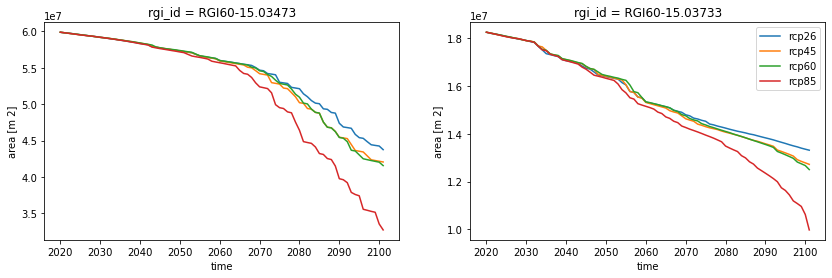

In [35]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 4))
for rcp in ['rcp26', 'rcp45', 'rcp60', 'rcp85']:
    rid = f'_CCSM4_{rcp}'
    ds = utils.compile_run_output(gdirs, input_filesuffix=rid)
    ds.isel(rgi_id=0).area.plot(ax=ax1, label=rcp)
    ds.isel(rgi_id=1).area.plot(ax=ax2, label=rcp)
plt.legend();

# Monthly outputs
Since annual outputs seems to be working, lets try and see what the monthly outputs are doing.

In [41]:
cfg.PARAMS['use_multiprocessing'] = True

2021-04-19 09:29:20: oggm.cfg: Multiprocessing switched ON after user settings.


In [43]:
for rcp in ['rcp26', 'rcp45', 'rcp60', 'rcp85']:
    rid = f'_CCSM4_{rcp}'
    workflow.execute_entity_task(tasks.run_with_hydro,
                                 gdirs,
                                 run_task=tasks.run_from_climate_data,
                                 climate_filename='gcm_data',
                                 climate_input_filesuffix=rid,
                                 mb_elev_feedback='monthly',
                                 store_monthly_step=True,
                                 init_model_filesuffix='_historical',
                                 output_filesuffix='_monthly_hydro_' + rid,
                                );

2021-04-19 09:39:54: oggm.workflow: Execute entity task run_with_hydro on 2 glaciers


ValueError: Unable to update size for existing dimension'time' (82 != 973)